#  Image Tampering Detection 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

sns.set(style='white', context='notebook', palette='deep')

## Initial preparation

In [9]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

#### Functions

In [6]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

In [7]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

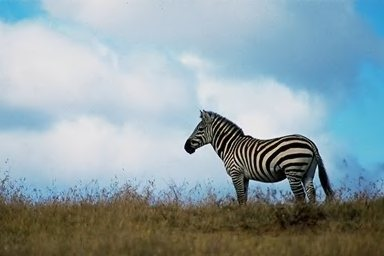

In [10]:
Image.open('C:/Users/ASUS/Desktop/EDAI/CASIA2/Au/Au_ani_00001.jpg')

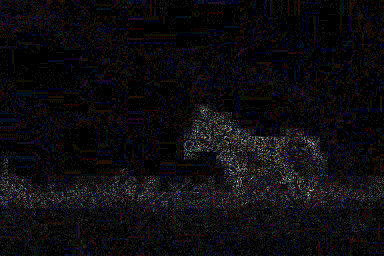

In [11]:
convert_to_ela_image('C:/Users/ASUS/Desktop/EDAI/CASIA2/Au/Au_ani_00001.jpg', 90)

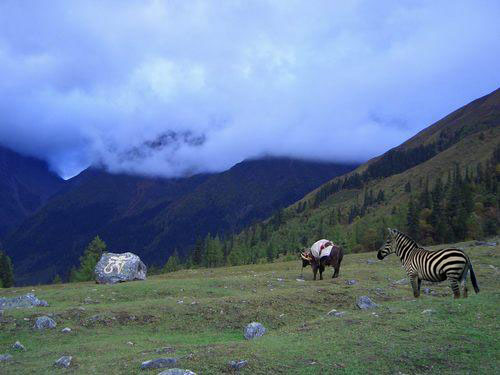

In [12]:
Image.open('C:/Users/ASUS/Desktop/EDAI/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg')

This is the result of the fake image after getting through ELA. We can compare the difference between the picture below and the real picture's ELA result.

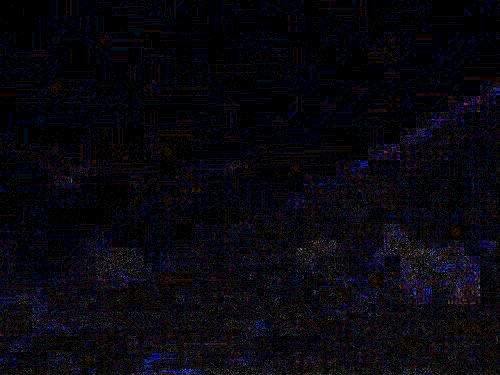

In [23]:
convert_to_ela_image('C:/Users/ASUS/Desktop/EDAI/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg', 90)

## Data preparation

### Read dataset and conversion to ELA

In [10]:
dataset = pd.read_csv('C:/Users/ASUS/Desktop/EDAI/dataset_CASIA2.csv')

In [11]:
X = []
Y = [].

In [12]:
for index, row in dataset.iterrows():
    X.append(array(convert_to_ela_image(row[0], 90).resize((128, 128))).flatten() / 255.0)
    Y.append(row[1])

### Normalization

In [13]:
X = np.array(X)
Y = to_categorical(Y, 2)

### Reshape X

In [14]:
X = X.reshape(-1, 128, 128, 3)

## Train-test split

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

## CNN building

In [16]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

Input:  (None, 128, 128, 3)
Output:  (None, 124, 124, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 120, 120, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 60, 60, 32)


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

### Add optimizer

In [18]:
optimizer = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [19]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


### Define early stopping

In [24]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

### Model training

In [21]:
epochs = 30
batch_size = 100

In [25]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2, callbacks=[early_stopping])

Epoch 1/30
100/100 - 411s - loss: 0.3326 - accuracy: 0.8623 - val_loss: 0.4207 - val_accuracy: 0.8116 - 411s/epoch - 4s/step
Epoch 2/30
100/100 - 437s - loss: 0.3015 - accuracy: 0.8754 - val_loss: 0.2737 - val_accuracy: 0.8922 - 437s/epoch - 4s/step
Epoch 3/30
100/100 - 439s - loss: 0.2831 - accuracy: 0.8827 - val_loss: 0.2481 - val_accuracy: 0.8958 - 439s/epoch - 4s/step
Epoch 4/30
100/100 - 438s - loss: 0.2633 - accuracy: 0.8864 - val_loss: 0.2417 - val_accuracy: 0.9002 - 438s/epoch - 4s/step
Epoch 5/30
100/100 - 504s - loss: 0.2351 - accuracy: 0.8991 - val_loss: 0.2448 - val_accuracy: 0.9014 - 504s/epoch - 5s/step
Epoch 6/30
100/100 - 475s - loss: 0.2159 - accuracy: 0.9095 - val_loss: 0.2291 - val_accuracy: 0.9002 - 475s/epoch - 5s/step
Epoch 7/30
100/100 - 462s - loss: 0.1938 - accuracy: 0.9184 - val_loss: 0.2423 - val_accuracy: 0.8922 - 462s/epoch - 5s/step


## Performance measure

### Accuracy and loss curves during training-validation

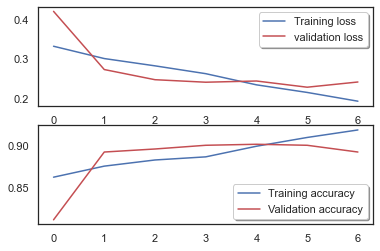

In [27]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Confusion matrix

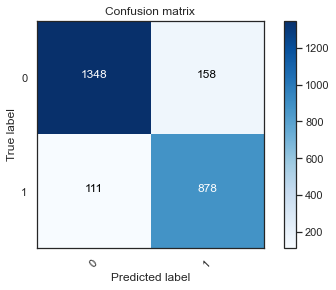

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [97]:
import keras
from keras.preprocessing.image import load_img, img_to_array 
import PIL

from tkinter.filedialog import askopenfilename
from tkinter.filedialog import *

path = askopenfilename()
X = []
X.append(array(convert_to_ela_image(path, 90).resize((128, 128))).flatten() / 255.0)
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)
prediction=np.argmax(model.predict(X))
labels=['Original','Tampered']

print(labels[prediction])
print(prediction)


Original
0


In [ ]:
model.save("model.h5")